# Linear Support Vector Machine Implementation using Quadratic Programming

This notebook implements a Linear Support Vector Machine (SVM) classifier from scratch using Quadratic Programming (QP) optimization. The implementation includes:

1. Custom SVM class using CVXOPT for QP optimization
2. Linear kernel implementation
3. Support vector visualization
4. Distance calculations to decision boundary
5. Detailed visualization of the decision boundary and support vectors

The goal is to demonstrate how SVM works internally and visualize its key components.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from cvxopt import matrix, solvers  # Import QP solver

## SVM Implementation using Quadratic Programming

The SVM implementation includes:
- Linear kernel computation
- QP formulation for optimization
- Support vector identification
- Decision boundary computation
- Distance calculations

In [2]:
class SVM_QP:
    def __init__(self, C=1.0):
        self.C = C
        self.alpha = None
        self.b = 0
        self.w = None
        self.X_train = None
        self.y_ = None

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def fit(self, X, y):
        self.X_train = X
        self.y_ = np.where(y <= 0, -1, 1)

        n_samples, n_features = X.shape

        # Compute Kernel Matrix
        K = np.dot(X, X.T)  # Linear kernel

        # Quadratic Programming Formulation
        P = matrix(np.outer(self.y_, self.y_) * K)  # Quadratic term
        q = matrix(-np.ones(n_samples))  # Linear term

        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))  # Inequality constraints
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))  # Bounds for alpha

        A = matrix(self.y_.astype(float), (1, n_samples))  # Equality constraint
        b = matrix(0.0)

        # Solve QP Problem
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        self.alpha = np.ravel(solution['x'])

        # Compute weight vector
        self.w = np.sum(self.alpha[:, None] * self.y_[:, None] * X, axis=0)

        # Compute bias using support vectors
        sv_indices = np.where((self.alpha > 1e-3) & (self.alpha < self.C - 1e-3))[0]
        if len(sv_indices) > 0:
            self.b = np.mean(self.y_[sv_indices] - np.dot(X[sv_indices], self.w))
        else:
            self.b = 0

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

    def decision_boundary_distance(self, X):
        """ Compute distance of points to the decision boundary """
        return np.abs(np.dot(X, self.w) + self.b) / np.linalg.norm(self.w)

## Data Generation

We'll generate linearly separable data with two classes:
- Class 0: Points around (1,1)
- Class 1: Points around (5,5)
- Gaussian noise added with σ=0.4

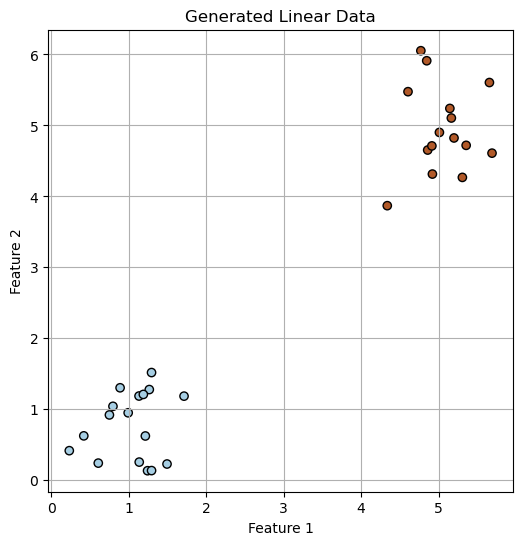

In [3]:
def generate_linear_data(n=20, test_ratio=0.2):
    data = []
    for _ in range(2 * n):
        x = 1 + random.gauss(0, 0.4)
        y = 1 + random.gauss(0, 0.4)
        data.append(([x, y], 0))
    for _ in range(2 * n):
        x = 5 + random.gauss(0, 0.4)
        y = 5 + random.gauss(0, 0.4)
        data.append(([x, y], 1))
    random.shuffle(data)
    split_idx = int(len(data) * (1 - test_ratio))
    return data[:split_idx], data[split_idx:]

# Generate and split data
train_data, test_data = generate_linear_data(n=10, test_ratio=0.2)
X_train = np.array([d[0] for d in train_data])
y_train = np.array([d[1] for d in train_data])
X_test = np.array([d[0] for d in test_data])
y_test = np.array([d[1] for d in test_data])

# Visualize the raw data
plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
plt.title("Generated Linear Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

## Model Training and Evaluation

Let's train our SVM model and evaluate its performance on both training and test sets.

In [4]:
# Train SVM using QP
svm = SVM_QP(C=1.0)
svm.fit(X_train, y_train)

# Evaluate
train_pred = (svm.predict(X_train) + 1) // 2
test_pred = (svm.predict(X_test) + 1) // 2
train_accuracy = np.mean(train_pred == y_train)
test_accuracy = np.mean(test_pred == y_test)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 1.00


## Decision Boundary and Support Vector Visualization

We'll create a detailed visualization showing:
1. Decision boundary
2. All training points
3. Support vectors (points closest to the boundary)
4. Distance measurements from support vectors to the boundary

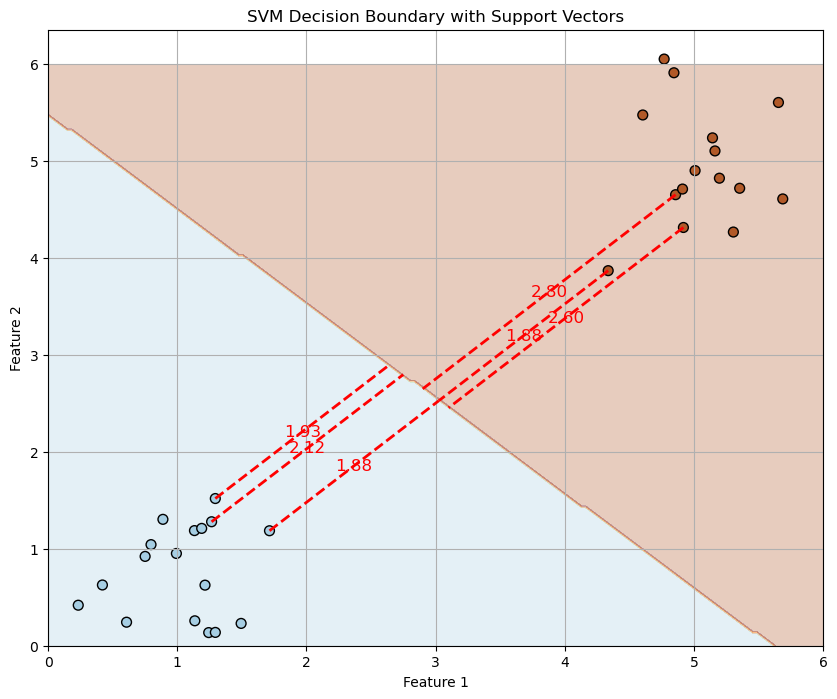

In [5]:
# Compute distances to decision boundary
distances = svm.decision_boundary_distance(X_train)

# Select 3 closest points from each class
class_0_idx = np.where(y_train == 0)[0]
class_1_idx = np.where(y_train == 1)[0]

closest_0 = class_0_idx[np.argsort(distances[class_0_idx])[:3]]
closest_1 = class_1_idx[np.argsort(distances[class_1_idx])[:3]]

# Create meshgrid for visualization
xx, yy = np.meshgrid(np.linspace(0, 6, 200), np.linspace(0, 6, 200))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = (Z + 1) // 2
Z = Z.reshape(xx.shape)

# Plot decision boundary with training data
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k', s=50)

# Draw lines from support vectors to decision boundary
for idx in np.concatenate((closest_0, closest_1)):
    point = X_train[idx]
    
    # Compute the projection of the point onto the decision boundary
    proj = point - (np.dot(point, svm.w) + svm.b) / np.dot(svm.w, svm.w) * svm.w

    # Draw line
    plt.plot([point[0], proj[0]], [point[1], proj[1]], 'r--', linewidth=2)

    # Annotate with distance
    dist = distances[idx]
    mid_x = (point[0] + proj[0]) / 2
    mid_y = (point[1] + proj[1]) / 2
    plt.text(mid_x, mid_y, f"{dist:.2f}", fontsize=12, color='red', ha='center', va='center')

plt.title("SVM Decision Boundary with Support Vectors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

## Conclusions

This implementation demonstrates:
1. How SVM finds the optimal separating hyperplane using Quadratic Programming
2. The role of support vectors in defining the decision boundary
3. How distances to the decision boundary are calculated
4. The effectiveness of SVM for linearly separable data

The visualization shows both the decision boundary and the actual margin width through the distance measurements to the closest points (support vectors).